In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import xgboost as xg
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error 
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import json 

In [67]:
df_model = pd.read_csv("analysis_data.csv")
df_model.head()

,locality_name,region_name,price,value_per_sqft,area,construction_status,house_type,total_rooms,total_beds,new_resale,age
0,Tarwala Nagar,Nashik,8499000.0,3761,2260,Under Construction,Apartment,6,4,New,-1.0
1,Dombivali,Mumbai,6790000.0,13580,500,Under Construction,Apartment,4,2,New,0.0
2,Wagholi,Pune,6030000.0,7811,773,Under Construction,Apartment,5,3,New,-3.0
3,Ambegaon Budruk,Pune,3537000.0,7417,477,Ready to move,Apartment,3,1,New,0.5
4,Dombivali,Mumbai,9500000.0,10359,917,Under Construction,Apartment,5,3,New,-3.0


In [68]:
df_model['region_name'] = ["Nashik" if i=="Nasik" else i for i in df_model['region_name'] ]

In [69]:
#Removing value_per_sqft as we have price as dependent variable!
df_model.drop(['value_per_sqft'],axis=1,inplace=True)
df_model.head()

,locality_name,region_name,price,area,construction_status,house_type,total_rooms,total_beds,new_resale,age
0,Tarwala Nagar,Nashik,8499000.0,2260,Under Construction,Apartment,6,4,New,-1.0
1,Dombivali,Mumbai,6790000.0,500,Under Construction,Apartment,4,2,New,0.0
2,Wagholi,Pune,6030000.0,773,Under Construction,Apartment,5,3,New,-3.0
3,Ambegaon Budruk,Pune,3537000.0,477,Ready to move,Apartment,3,1,New,0.5
4,Dombivali,Mumbai,9500000.0,917,Under Construction,Apartment,5,3,New,-3.0


In [70]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

df_model['locality_name_enc'] = labelencoder.fit_transform(df_model['locality_name'])
df_model['region_name_enc'] = labelencoder.fit_transform(df_model['region_name'])
df_model.head()

,locality_name,region_name,price,area,construction_status,house_type,total_rooms,total_beds,new_resale,age,locality_name_enc,region_name_enc
0,Tarwala Nagar,Nashik,8499000.0,2260,Under Construction,Apartment,6,4,New,-1.0,1412,21
1,Dombivali,Mumbai,6790000.0,500,Under Construction,Apartment,4,2,New,0.0,351,17
2,Wagholi,Pune,6030000.0,773,Under Construction,Apartment,5,3,New,-3.0,1575,25
3,Ambegaon Budruk,Pune,3537000.0,477,Ready to move,Apartment,3,1,New,0.5,39,25
4,Dombivali,Mumbai,9500000.0,917,Under Construction,Apartment,5,3,New,-3.0,351,17


In [73]:
d_loc_enc = dict(zip(df_model['locality_name'],df_model['locality_name_enc']))
d_reg_enc = dict(zip(df_model['region_name'],df_model['region_name_enc']))

with open("d_loc_enc.json", "w") as outfile:
    json.dump(d_loc_enc, outfile)
    
with open("d_reg_enc.json", "w") as outfile:
    json.dump(d_reg_enc, outfile)

In [74]:
df_model['locality_name'] = df_model['locality_name_enc']
df_model['region_name'] = df_model['region_name_enc']
df_model.drop(['locality_name_enc','region_name_enc'],axis=1,inplace=True)

In [75]:
#Converting price into crores
df_model['price'] = df_model['price']/(10**7)

In [76]:
cs_df = pd.get_dummies(df_model['construction_status'], columns=["construction_status"], prefix= "construction_status_" )
new_resale_df = pd.get_dummies(df_model['new_resale'], columns=["new_resale"], prefix="new_resale_" )
house_type_df = pd.get_dummies(df_model['house_type'], columns=["house_type"], prefix= "house_type_")
df_model = pd.concat([df_model,cs_df,new_resale_df,house_type_df],axis=1)
df_model.drop(['construction_status','house_type','new_resale'],axis=1,inplace=True)
df_model.head()

,locality_name,region_name,price,area,total_rooms,total_beds,age,construction_status__Ready to move,construction_status__Under Construction,new_resale__New,new_resale__Resale,new_resale__old,house_type__Apartment,house_type__Independent Floor,house_type__Independent House,house_type__Penthouse,house_type__Studio Apartment,house_type__Villa
0,1412,21,8.499000e-08,2260,6,4,-1.0,0,1,1,0,0,1,0,0,0,0,0
1,351,17,6.790000e-08,500,4,2,0.0,0,1,1,0,0,1,0,0,0,0,0
2,1575,25,6.030000e-08,773,5,3,-3.0,0,1,1,0,0,1,0,0,0,0,0
3,39,25,3.537000e-08,477,3,1,0.5,1,0,1,0,0,1,0,0,0,0,0
4,351,17,9.500000e-08,917,5,3,-3.0,0,1,1,0,0,1,0,0,0,0,0


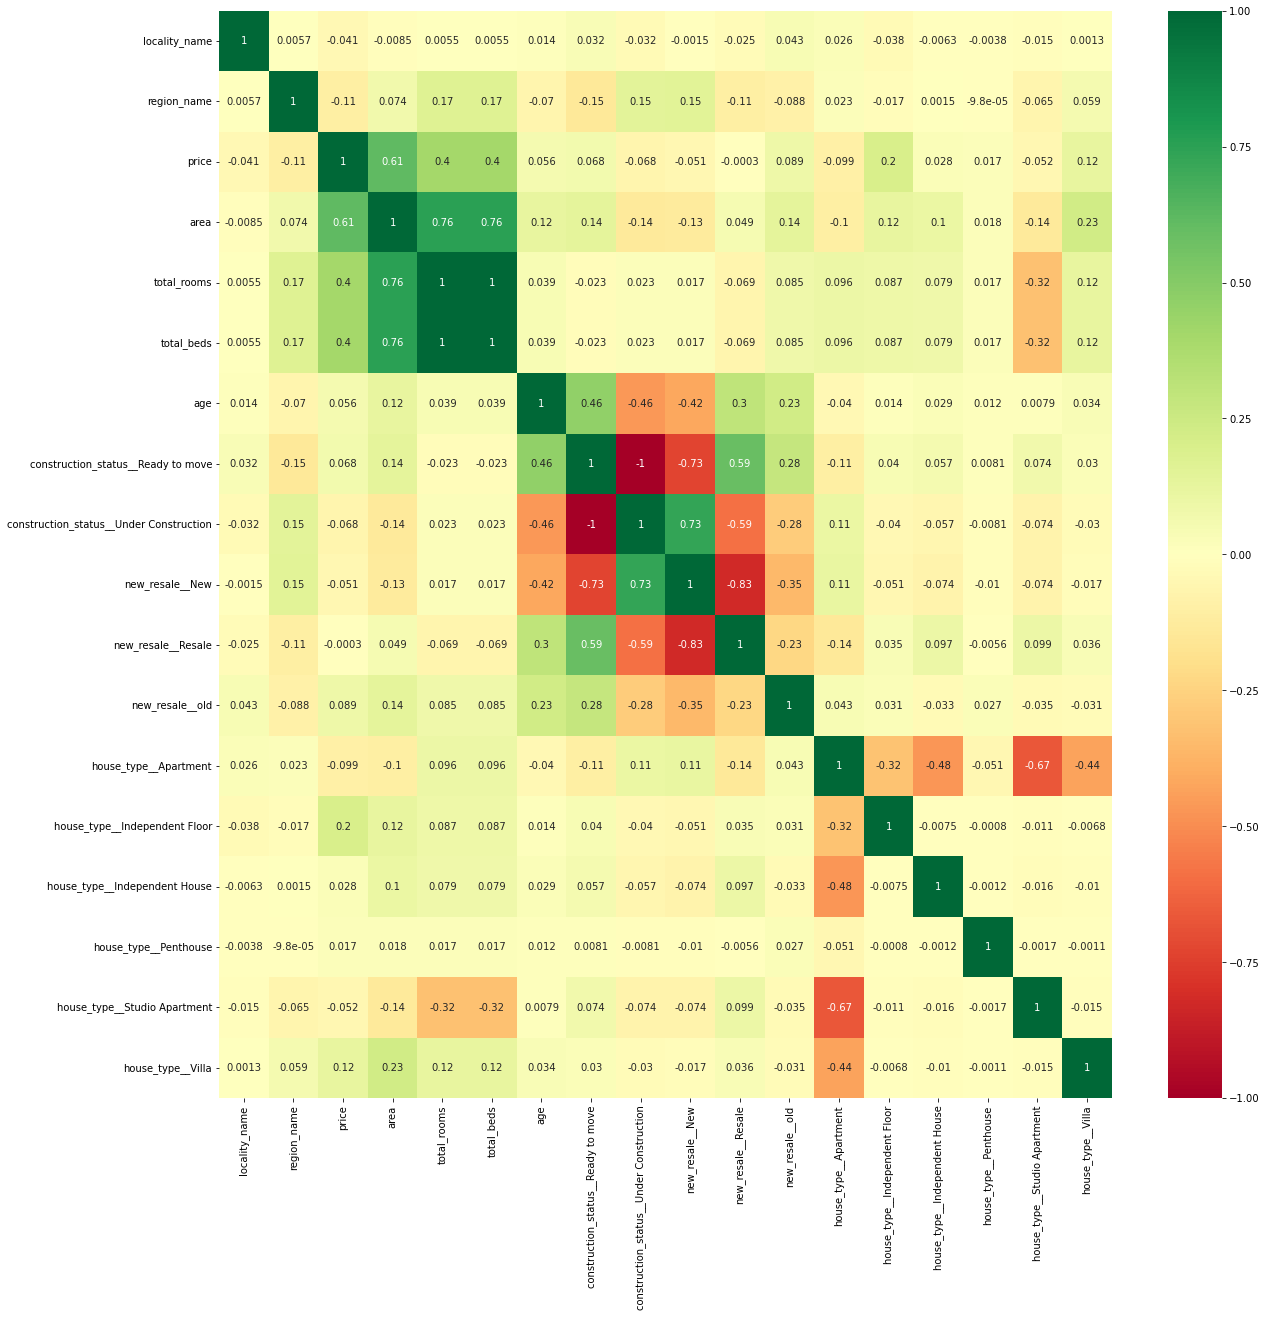

In [32]:
import seaborn as sns
#get correlations of each features in dataset
corrmat = df_model.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(df_model[top_corr_features].corr(),annot=True,cmap="RdYlGn")

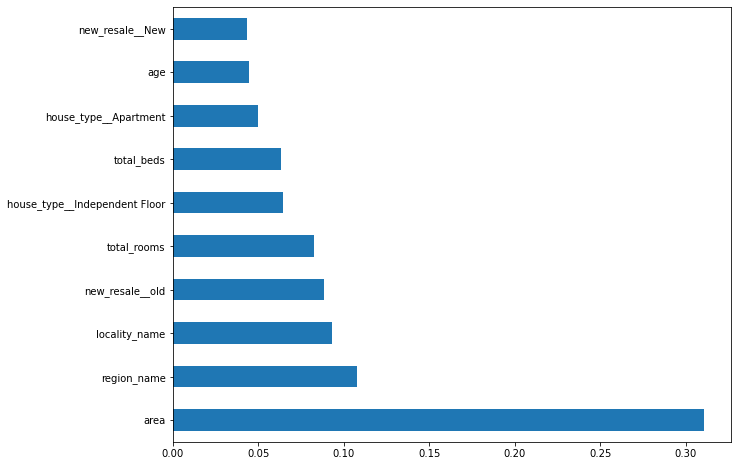

In [33]:
X = df_model.drop('price',axis=1)
y = df_model['price']
  
model = ExtraTreesRegressor()
model.fit(X,y)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
plt.figure(figsize=(10,8))
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [34]:
# scaler = StandardScaler()
# X = scaler.fit_transform(X)

# Splitting
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.3, random_state = 123)
  
# Instantiation
xgb_base_model = xg.XGBRegressor(objective ='reg:squarederror', n_estimators = 10, seed = 123)
  
# Fitting the model
xgb_base_model.fit(train_X, train_y)
  
# Predict the model
pred = xgb_base_model.predict(test_X)
pred_train = xgb_base_model.predict(train_X)  

# RMSE Computation
rmse_base_train = np.sqrt(MSE(train_y, pred_train))
rmse_base_test = np.sqrt(MSE(test_y, pred))
mae_xgb_base = mean_absolute_error(test_y, pred)

r2Score = r2_score(test_y, pred)
print("RMSE Train: % f" %(rmse_base_train))
print("RMSE Test: % f" %(rmse_base_test))
print("MAE: ", mae_xgb_base)
print("R2 Score: ", r2Score)

RMSE Train:  1.125320
RMSE Test:  1.279477
MAE:  0.4587660225530372
R2 Score:  0.8392882432567957


In [35]:
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

def hyperParameterTuning(X_train, y_train):
    param_tuning = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 6, 10],
        'min_child_weight': [1, 3],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 300],
        'objective': ['reg:squarederror']
    }

    xgb_model =  xg.XGBRegressor()

    gsearch = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,                        
                           #scoring = 'neg_mean_absolute_error', #MAE
                           scoring = 'neg_mean_squared_error',  #MSE
                           cv = 3,
                           n_jobs = -1,
                           verbose = 2)

    gsearch.fit(X_train,y_train)

    return gsearch.best_params_

In [36]:
# hyperParameterTuning(train_X, train_y)

In [37]:
xgb_model = xg.XGBRegressor(
        objective = 'reg:squarederror',
        colsample_bytree =0.5,
        learning_rate = 0.1,
        max_depth = 20,
        min_child_weight = 3,
        n_estimators = 1000,
        subsample =  0.5)

%time xgb_model.fit(train_X, train_y, early_stopping_rounds=5, eval_set=[(test_X, test_y)], verbose=False)

y_pred_xgb = xgb_model.predict(test_X)
y_pred_xgb_train = xgb_model.predict(train_X)


mae_xgb = mean_absolute_error(test_y, y_pred_xgb)
r2Score = r2_score(test_y, y_pred_xgb)
rmse_train = np.sqrt(MSE(train_y, y_pred_xgb_train))
rmse_test = np.sqrt(MSE(test_y, y_pred_xgb))

print("RMSE Train (fine tuned): % f" %(rmse_train))
print("RMSE Test (fine tuned): % f" %(rmse_test))
print("MAE: ", mae_xgb)
print("R2 Score: ", r2Score)

Wall time: 6.17 s
RMSE Train (fine tuned):  0.654203
RMSE Test (fine tuned):  0.995787
MAE:  0.23471834210637152
R2 Score:  0.9026545641383122


Text(0, 0.5, 'pred_y')

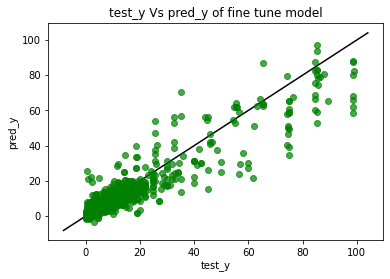

In [38]:
fig, ax = plt.subplots()
ax.scatter(test_y,y_pred_xgb,alpha=0.7,color='g')
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', zorder=0)
ax.title.set_text('test_y Vs pred_y of fine tune model')
ax.set_xlabel('test_y')
ax.set_ylabel('pred_y')


Text(0, 0.5, 'pred_y')

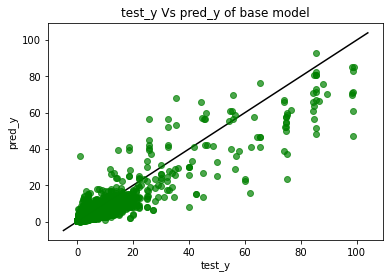

In [39]:
fig, ax = plt.subplots()
ax.scatter(test_y,pred,alpha=0.7,color='g')
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', zorder=0)
ax.title.set_text('test_y Vs pred_y of base model')
ax.set_xlabel('test_y')
ax.set_ylabel('pred_y')

In [40]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

cv = KFold(n_splits=5)

# evaluate model
scores = cross_val_score(xgb_base_model, X, y , scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
scores_bm = cross_val_score(xgb_model, X, y , scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = abs(scores)
scores_bm = abs(scores_bm)
print('Mean RMSE xgb base model: %.3f (%.3f)' % (scores.mean(), scores.std()) )
print('Mean RMSE xgb best hyperparameter tuned model: %.3f (%.3f)' % (scores_bm.mean(), scores_bm.std()) )

Mean RMSE xgb base model: 1.386 (0.495)
Mean RMSE xgb best hyperparameter tuned model: 1.206 (0.515)


In [ ]:
test = pd.DataFrame(dict(zip(['locality_name', 'region_name', 'area', 'total_rooms', 'total_beds',
       'age', 'construction_status__Ready to move', 'construction_status__Under Construction', 'new_resale__New',
       'new_resale__Resale', 'new_resale__old', 'house_type__Apartment',
       'house_type__Independent Floor', 'house_type__Independent House',
       'house_type__Penthouse', 'house_type__Studio Apartment',
       'house_type__Villa'],[[446],[17],[678],[2],[1],[-3.0],[0],[1],[1],[0],[0],[1],[0],[0],[0],[0],[0]])))

In [48]:
xgb_model.predict(test)[0]

1.0794346

In [15]:
unique_regions = set(df_model['region_name']) 
d_region_loc = {}
for reg in unique_regions:
    d_region_loc.update({reg: list(set(df_model[df_model['region_name']==reg]['locality_name']))})

d_region_loc

{' Jalna': ['Ghansawangi', 'Modikhana', 'Indewadi'],
 ' Amravati': ['Sai Nagar',
  'New Ganesh Colony',
  'Saturna',
  'Shegaon Rahatgaon Road',
  'Badnera',
  'Kathora Road',
  'Gopal Nagar',
  'Akoli',
  'Paradise Colony',
  'Arjun Nagar',
  'Moti Nagar',
  'Kathora',
  'Camp Road',
  'Shankar Nagar Road',
  'Dastur Nagar',
  'Rajapeth',
  'Vivekanand Colony',
  'Rahatgaon',
  'Navsaari',
  'Mangaldham Colony',
  'Shyam Nagar',
  'Parvati Nagar',
  'Maltekdi'],
 ' Jalgaon': ['Old MIDC',
  'Pimparla',
  'Pimprala Shivar',
  'Samata Nagar',
  'Ganesh Colony',
  'Ramanand Nagar',
  'Dadawadi',
  'Muktainagar',
  'Harivitthal Nagar',
  'Khote Nagar',
  'Samrth Nagar',
  'Devendra Nagar',
  'Anil Nagar',
  'Mehrun',
  'Renuka Mata Nagar',
  'MIDC',
  'Ganpati Nagar',
  'Gadkari Nagar',
  'Mahavir Nagar'],
 ' Hingoli': ['Chandgavhan',
  'Aral',
  'Chikhalwadi',
  'Patil Nagar',
  'Khed',
  'Puyana'],
 ' Latur': ['Maharana Pratap Nagar',
  'Vishwanathpuram',
  'Sawe Wadi',
  'Ganj Golai'],


In [16]:


with open("d_region_loc.json", "w") as outfile:
    json.dump(d_region_loc, outfile)


In [12]:
df_model['house_type'].unique()

array(['Apartment', 'Independent House', 'Villa', 'Studio Apartment',
       'Independent Floor', 'Penthouse'], dtype=object)

In [21]:
d_region_loc.keys()

dict_keys([' Jalna', ' Amravati', ' Jalgaon', ' Hingoli', ' Latur', ' Solapur', ' Satara', ' Vikramgad', ' Dhule', ' Nagpur', ' Baramati', ' Sangli', ' Pune', ' Nandurbar', ' Akola', ' Alibaugh', ' Beed', ' Bhandara', ' Aurangabad', ' Sindhudurg', ' Shirdi', ' Mumbai', ' Nanded', ' Ahmednagar', ' Parbhani', ' Ratnagiri', ' Kolhapur', ' Raigad', ' Yavatmal', ' Osmanabad', ' Nasik', ' Nashik', ' Wardha', ' Chandrapur', ' Buldana', ' Lonikand'])

In [49]:
import pickle
filename = 'xgb_house_predict.pkl'
pickle.dump(xgb_model, open(filename, 'wb'))

In [46]:
X.columns

Index(['locality_name', 'region_name', 'area', 'total_rooms', 'total_beds',
       'age', 'construction_status__Ready to move',
       'construction_status__Under Construction', 'new_resale__New',
       'new_resale__Resale', 'new_resale__old', 'house_type__Apartment',
       'house_type__Independent Floor', 'house_type__Independent House',
       'house_type__Penthouse', 'house_type__Studio Apartment',
       'house_type__Villa'],
      dtype='object')